1. Загружаем сэмплы
2. Новые точки
3. Считаем для них MC оценки


In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
from matplotlib import pyplot as plt
%matplotlib inline

In [56]:
import torch

In [57]:
from tqdm import tqdm

In [33]:
!pip install --upgrade torch

Requirement already up-to-date: torch in /home/vsamohin/miniconda3/lib/python3.6/site-packages (1.6.0)


In [58]:
from easydict import EasyDict as edict
args = {
    'bnn_lr': 1e-3,
    'cv_lr': 1e-3,
    'n_cv_iter': 100,
    'batch_size' : 100,
    'input_dim' : 784,
    'width' : 100,
    'depth' : 2,
    'output_dim' : 2,
    'n_epoch' : 200,
    'alpha0' : 10, 
    'beta0' : 10,
    'resample_prior_every' : 15,
    'resample_momentum_every' : 50,
    'burn_in_epochs' : 20,
    'save_freq' : 4,
    'resample_prior_until' : 100,
    'report_every' : 10,
    }

args = edict(args)

In [59]:
import pickle
from copy import deepcopy
with open('../data/100_samples_seed42.pkl', 'rb') as fp:
    samples = pickle.load(fp)

In [60]:
import sys
sys.path.append('..')

In [61]:
from control_variates.model import LogRegression

In [62]:
from mnist_utils import load_mnist_dataset

In [63]:
train_dl, valid_dl = load_mnist_dataset('../data/mnist/', args.batch_size, classes=[3, 5])

In [64]:
N_train = len(train_dl.dataset)

In [65]:
trajectories = [[LogRegression(args.input_dim)
                 for j in range(len(samples[i][0]))]
                for i in range(len(samples))]

for i in range(len(samples)):
    for j in range(len(samples[i][0])):
        trajectories[i][j].load_state_dict(samples[i][0][j])

priors = [samples[i][1] for i in range(len(samples))]

In [66]:
trajectories[0][1]

LogRegression(
  (linear): Linear(in_features=784, out_features=2, bias=True)
)

In [67]:
x_new, y_new = next(iter(train_dl))
train_x, train_y = next(iter(valid_dl))

Фитим ncv

In [68]:
from control_variates.cv import PsyLinear, SteinCV
from control_variates.cv_utils import state_dict_to_vec, compute_naive_variance
from control_variates.model import get_binary_prediction
import numpy as np

In [69]:
from control_variates.uncertainty_quantification import ClassificationUncertaintyMCMC

In [70]:
psy_input_dim

1570

In [72]:
tqdm._instances.clear()

100%|██████████| 100/100 [00:33<00:00,  3.24it/s]


3.4650089464349776e-09 2.340700575587107e-06


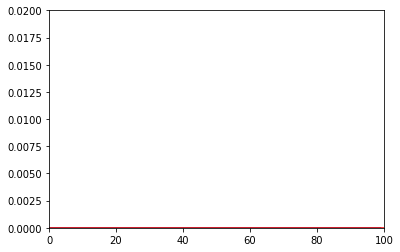

100%|██████████| 100/100 [00:31<00:00,  3.45it/s]

2.843461466284225e-09 1.3297293435243773e-06


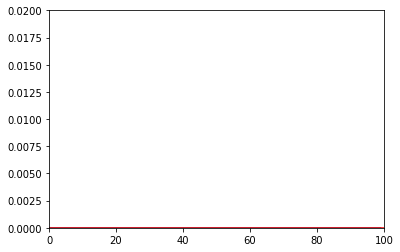

100%|██████████| 100/100 [00:31<00:00,  3.81it/s]

3.4557419148484314e-09 1.671564746175136e-06


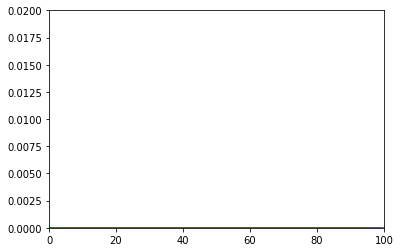

100%|██████████| 100/100 [00:28<00:00,  3.91it/s]

4.947646736752631e-09 3.279892325736e-06


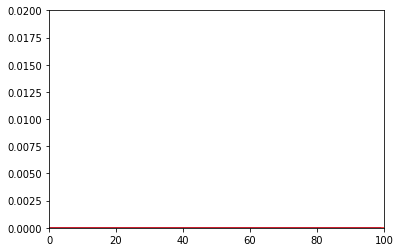

100%|██████████| 100/100 [00:31<00:00,  3.51it/s]

1.4435897810471943e-08 1.2828523949792725e-06


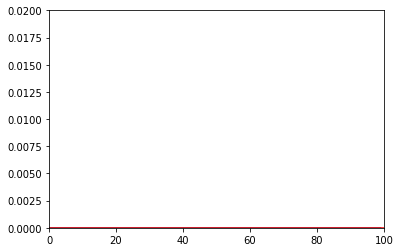

100%|██████████| 100/100 [00:29<00:00,  3.40it/s]

2.6774949901664513e-07 2.5406500299141044e-06


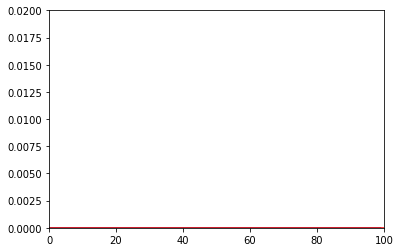

100%|██████████| 100/100 [00:33<00:00,  2.99it/s]

2.2679707001316274e-09 2.0420097257556336e-07


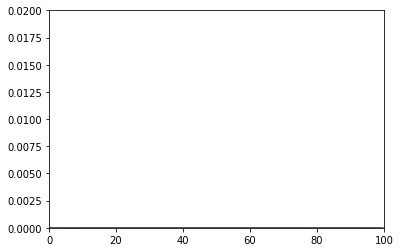

100%|██████████| 100/100 [00:30<00:00,  3.15it/s]

1.4017518878972623e-07 4.421675839694217e-06


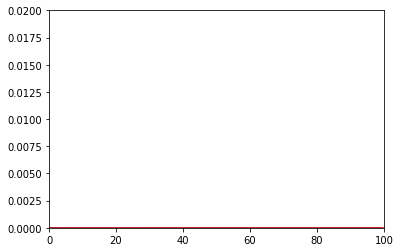

100%|██████████| 100/100 [00:34<00:00,  3.53it/s]


2.873289828286829e-09 1.3811427379550878e-06


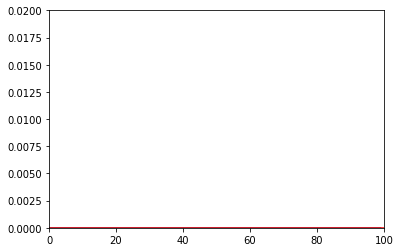

100%|██████████| 100/100 [00:30<00:00,  4.23it/s]

1.8900028209145603e-09 8.272739933090634e-07


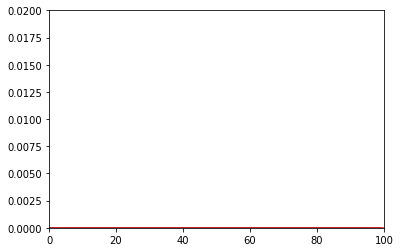

100%|██████████| 100/100 [00:33<00:00,  3.15it/s]

6.309615230293275e-08 3.1648536946704553e-07


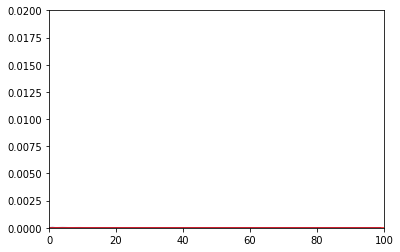

100%|██████████| 100/100 [00:30<00:00,  3.39it/s]

4.6887819848961954e-07 1.6890543292902294e-06


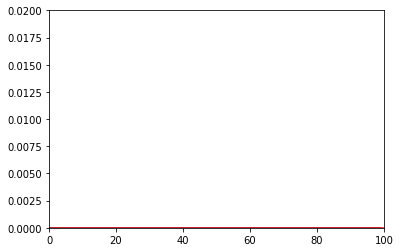

100%|██████████| 100/100 [00:34<00:00,  3.41it/s]

1.4903585032755018e-09 2.812446382449707e-07


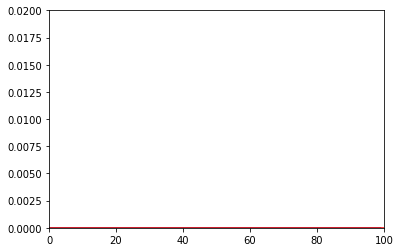

100%|██████████| 100/100 [00:30<00:00,  1.95it/s]

1.2657173087404772e-09 6.527219511553994e-07


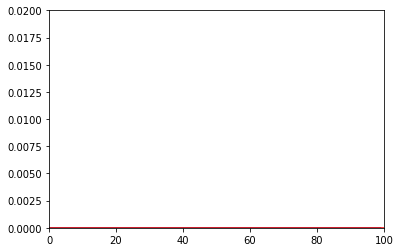

100%|██████████| 100/100 [00:34<00:00,  3.24it/s]

2.62819610519216e-09 1.4509660104522482e-06


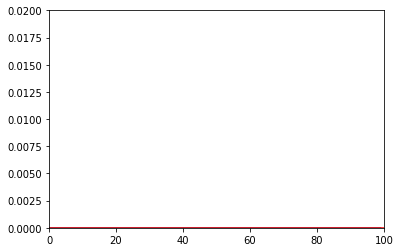

100%|██████████| 100/100 [00:35<00:00,  2.32it/s]

3.3225451279150775e-09 1.0608697920133636e-07


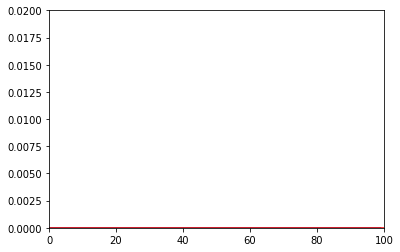

100%|██████████| 100/100 [00:32<00:00,  3.89it/s]

8.916837046513137e-09 5.989104920445243e-06


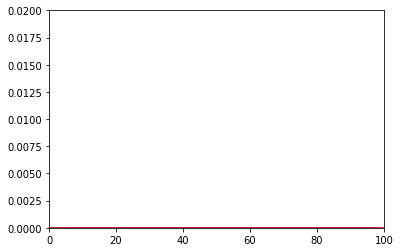

100%|██████████| 100/100 [00:35<00:00,  3.15it/s]

1.7338551927537083e-08 4.5961593286847346e-07


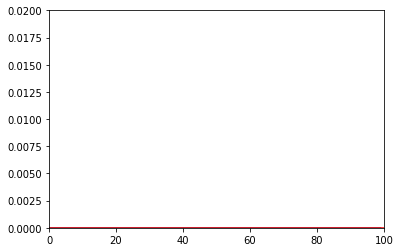

100%|██████████| 100/100 [00:32<00:00,  3.61it/s]

2.6834058530766924e-08 1.0917934787357808e-06


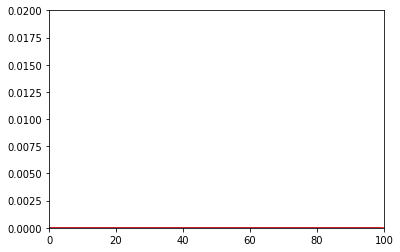

100%|██████████| 100/100 [00:31<00:00,  3.98it/s]

3.0685772145488954e-08 3.469824036983482e-07


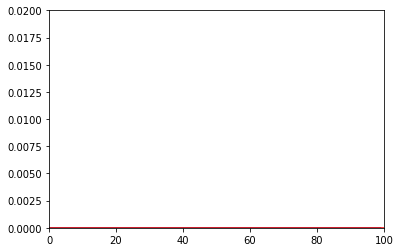

100%|██████████| 100/100 [00:31<00:00,  4.28it/s]


2.805351506651732e-09 4.278108917787904e-06


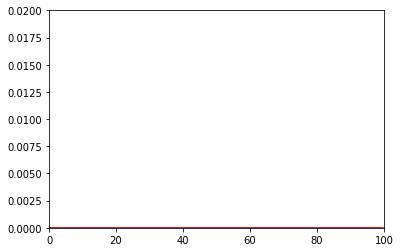

100%|██████████| 100/100 [00:33<00:00,  2.45it/s]

1.3519374508774717e-09 4.143896319419582e-07


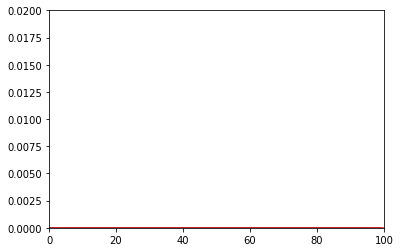

100%|██████████| 100/100 [00:30<00:00,  3.61it/s]

1.110944491955479e-08 9.346036677015945e-06


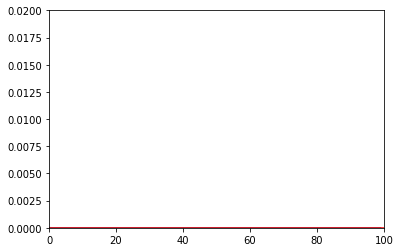

100%|██████████| 100/100 [00:32<00:00,  4.17it/s]

6.1280953644882175e-09 5.357773034120328e-07


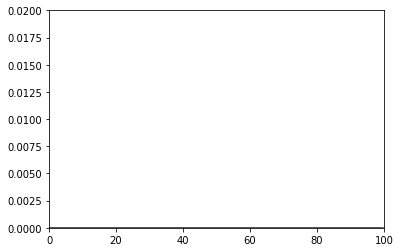

100%|██████████| 100/100 [00:33<00:00,  2.44it/s]

2.138797938755488e-08 4.089055892109172e-06


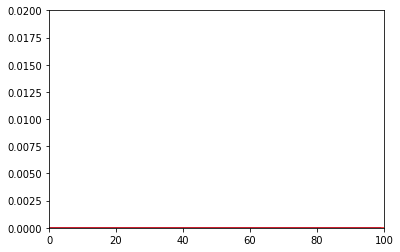

100%|██████████| 100/100 [00:29<00:00,  3.77it/s]

4.516833129741826e-09 3.302342292954563e-07


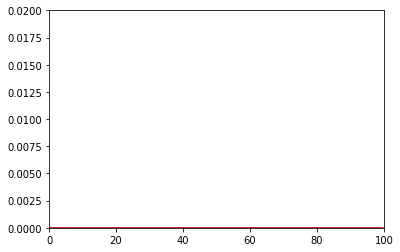

100%|██████████| 100/100 [00:34<00:00,  3.24it/s]

6.660041851347387e-09 2.9481577712431317e-06


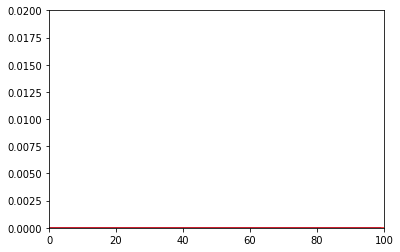

100%|██████████| 100/100 [00:32<00:00,  3.72it/s]

1.7508013927525212e-09 1.4734549722561496e-06


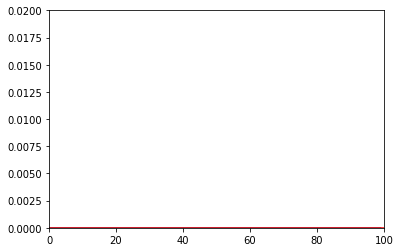

100%|██████████| 100/100 [00:33<00:00,  2.44it/s]

4.594490121689887e-09 9.461651302444807e-07


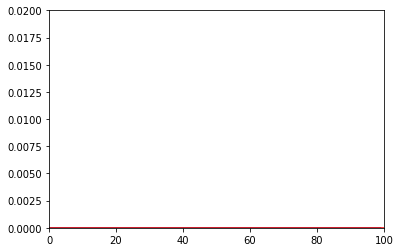

100%|██████████| 100/100 [00:31<00:00,  3.30it/s]

2.681588284758618e-09 1.0279554771841504e-06


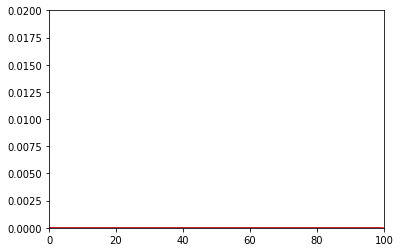

100%|██████████| 100/100 [00:32<00:00,  3.48it/s]

1.1851403058926735e-07 5.9238693211227655e-05


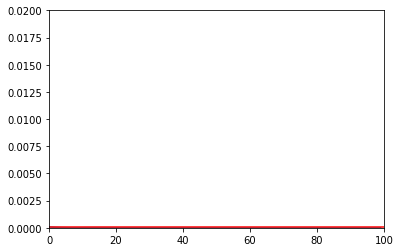

100%|██████████| 100/100 [00:32<00:00,  2.99it/s]

4.440033229968776e-09 4.283292653894932e-08


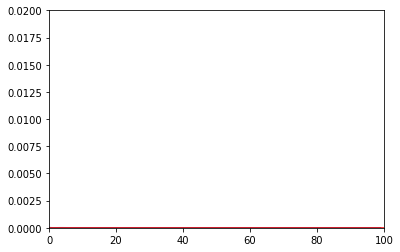

100%|██████████| 100/100 [00:31<00:00,  3.89it/s]

3.6115039847572916e-09 1.0911772960753297e-06


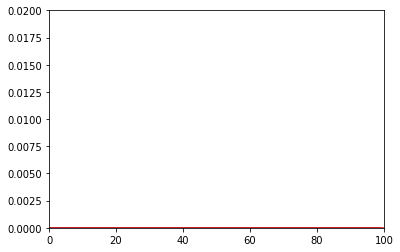

100%|██████████| 100/100 [00:30<00:00,  3.79it/s]

3.268268145006914e-08 4.4071616684959736e-06


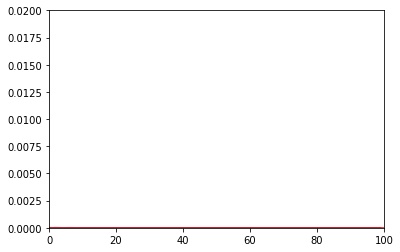

100%|██████████| 100/100 [00:33<00:00,  3.48it/s]

6.613662861809644e-08 2.1473342712852173e-05


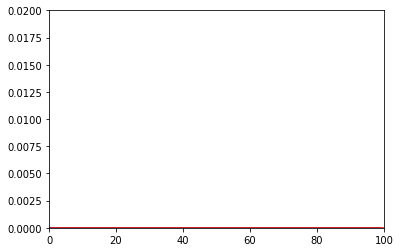

100%|██████████| 100/100 [00:30<00:00,  3.24it/s]

1.7506939231637375e-09 5.387561259340146e-07


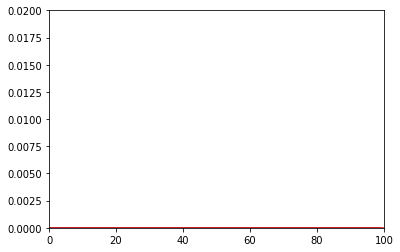

100%|██████████| 100/100 [00:33<00:00,  3.61it/s]

1.24611361229654e-07 6.301419944065856e-06


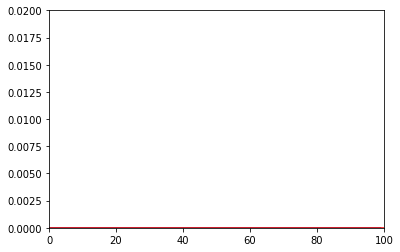

100%|██████████| 100/100 [00:33<00:00,  3.31it/s]

2.9344437990630468e-08 5.560133558901725e-06


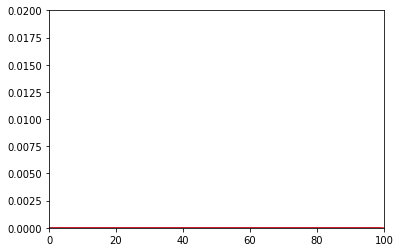

100%|██████████| 100/100 [00:31<00:00,  3.40it/s]

1.1303848523880333e-08 1.9263747219611105e-07


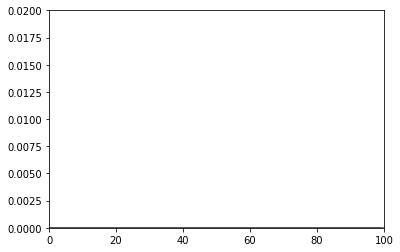

100%|██████████| 100/100 [00:33<00:00,  3.42it/s]

2.56845500423708e-09 2.469873550126067e-07


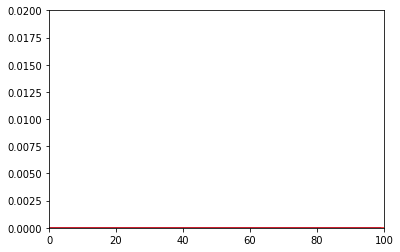

100%|██████████| 100/100 [00:30<00:00,  3.54it/s]

4.174980916538118e-10 1.6149169823620468e-07


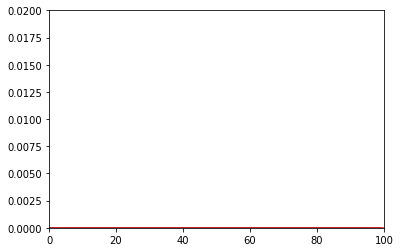

100%|██████████| 100/100 [00:34<00:00,  3.11it/s]

5.0809751961367056e-09 5.91104708291823e-07


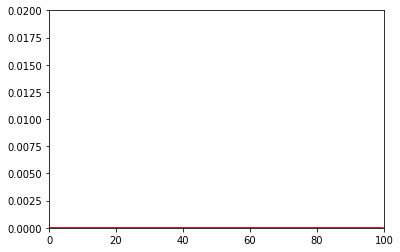

100%|██████████| 100/100 [00:30<00:00,  3.40it/s]

2.9425336833810434e-08 7.700080459471792e-06


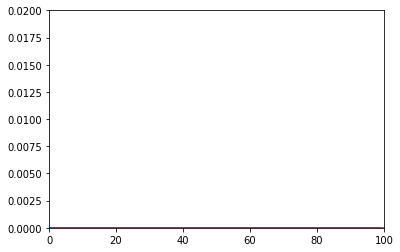

100%|██████████| 100/100 [00:32<00:00,  3.45it/s]

2.2662016263552687e-08 9.463661854169914e-07


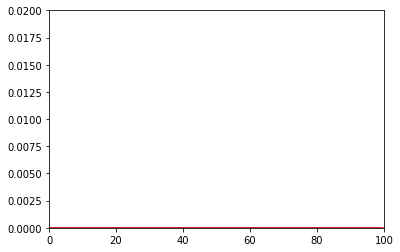

100%|██████████| 100/100 [00:30<00:00,  3.11it/s]

3.5079025906270545e-08 4.690623427450191e-06


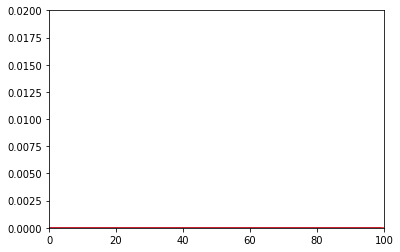

100%|██████████| 100/100 [00:33<00:00,  2.89it/s]

1.2685311689963896e-09 3.210896295513521e-07


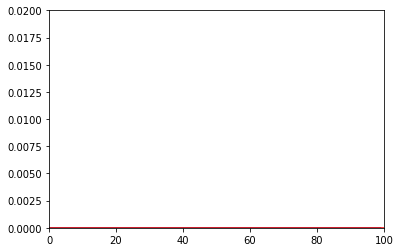

100%|██████████| 100/100 [00:30<00:00,  2.68it/s]


5.131996605456379e-09 8.233266726165311e-07


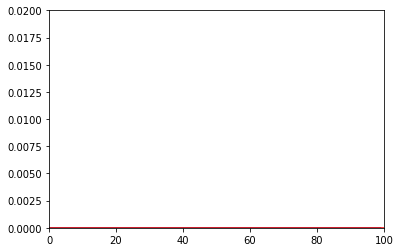

100%|██████████| 100/100 [00:35<00:00,  2.15it/s]

9.213704466048966e-09 1.2648568770146085e-07


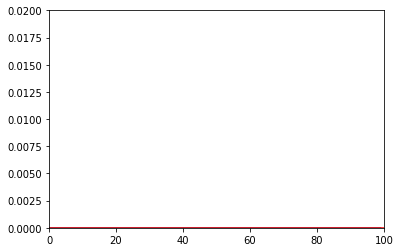

100%|██████████| 100/100 [00:34<00:00,  3.25it/s]

3.9120648942514435e-09 2.633818212416372e-07


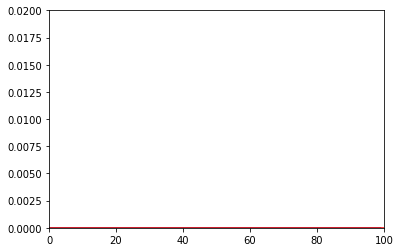

100%|██████████| 100/100 [00:31<00:00,  2.88it/s]

4.82180206873295e-09 3.5981233850179706e-06


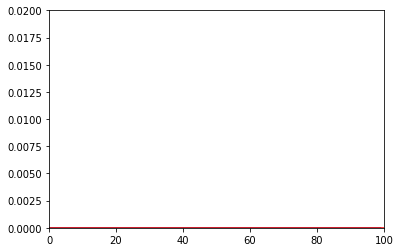

100%|██████████| 100/100 [00:32<00:00,  3.48it/s]

4.0016854541136126e-07 8.436304597125854e-06


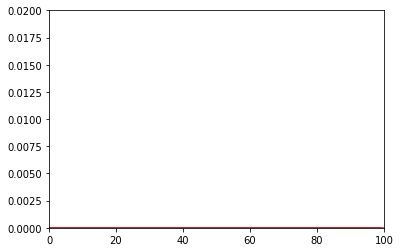

100%|██████████| 100/100 [00:31<00:00,  3.34it/s]

6.050552059377878e-08 9.963885531760752e-06


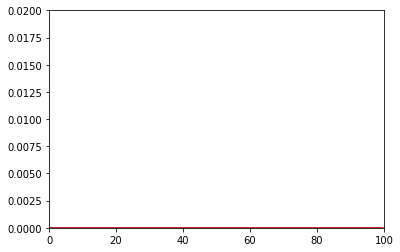

100%|██████████| 100/100 [00:34<00:00,  3.38it/s]

5.904869926354195e-09 8.387733032577671e-06


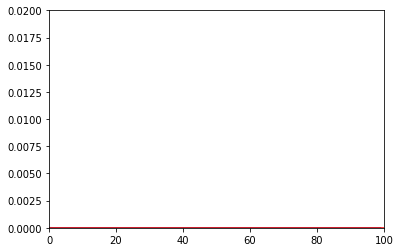

100%|██████████| 100/100 [00:31<00:00,  3.61it/s]

4.540706033395736e-09 3.2406560421804897e-06


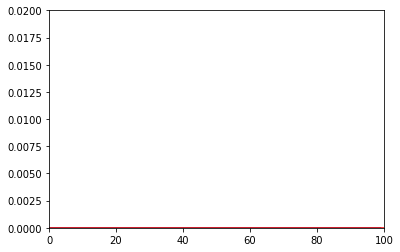

100%|██████████| 100/100 [00:34<00:00,  3.41it/s]

1.5232841654722051e-09 2.5517502422189864e-07


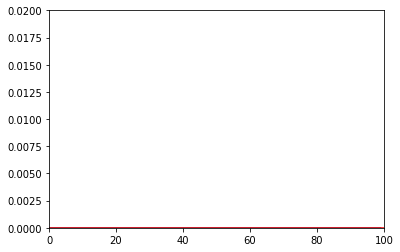

100%|██████████| 100/100 [00:31<00:00,  3.78it/s]

4.902292460862157e-10 7.36863299266588e-08


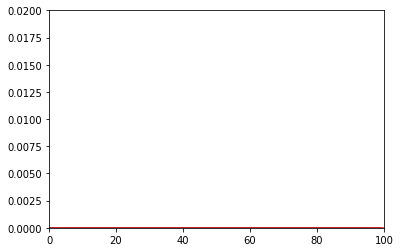

100%|██████████| 100/100 [00:33<00:00,  3.30it/s]

2.468680015965674e-08 9.260379556508269e-07


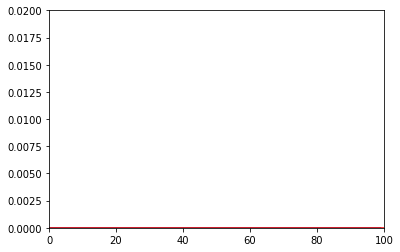

100%|██████████| 100/100 [00:35<00:00,  2.28it/s]

2.6719961354615407e-08 1.8862527213059366e-05


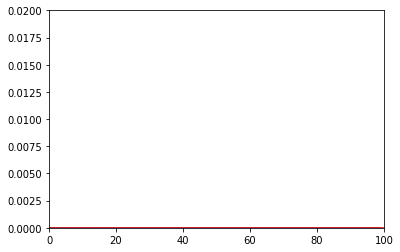

100%|██████████| 100/100 [00:32<00:00,  3.67it/s]

1.9818255925230233e-09 9.553352953162175e-08


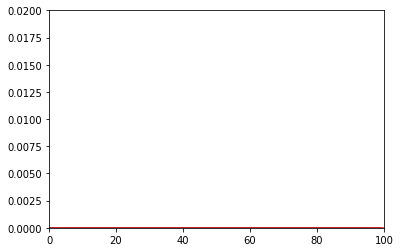

100%|██████████| 100/100 [00:33<00:00,  3.30it/s]

9.3372340970177e-09 3.876367372868117e-06


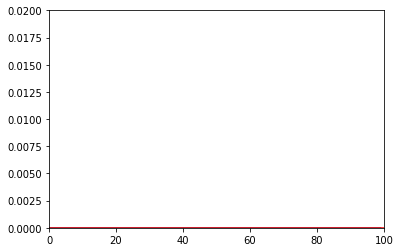

100%|██████████| 100/100 [00:30<00:00,  4.07it/s]

2.852310956313886e-07 1.8563431467555347e-06


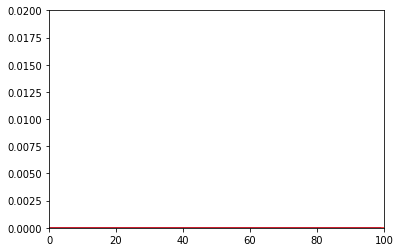

100%|██████████| 100/100 [00:35<00:00,  2.55it/s]

4.991674629195586e-09 3.3788312521210173e-06


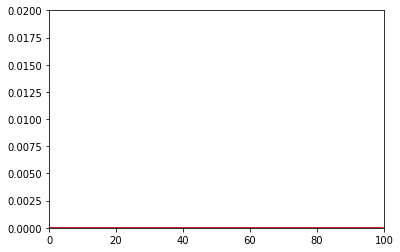

100%|██████████| 100/100 [00:31<00:00,  3.93it/s]

7.988849404227949e-08 3.5645439311338123e-07


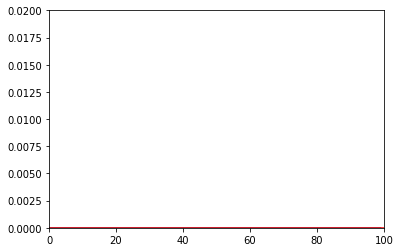

100%|██████████| 100/100 [00:32<00:00,  4.25it/s]

1.3215211147610262e-08 6.555766049132217e-06


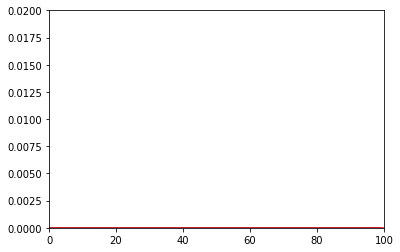

100%|██████████| 100/100 [00:29<00:00,  3.47it/s]

1.4892793664955661e-08 7.799735044500267e-07


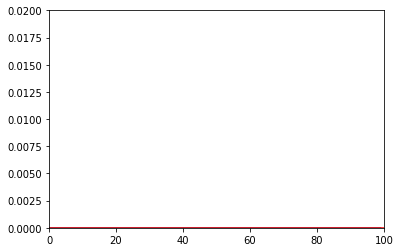

100%|██████████| 100/100 [00:33<00:00,  3.27it/s]

4.287052135509839e-08 3.25714182736192e-07


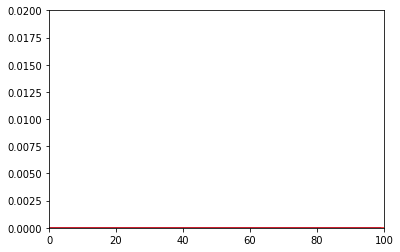

100%|██████████| 100/100 [00:30<00:00,  4.00it/s]

8.811563145805223e-10 1.6871872787760367e-07


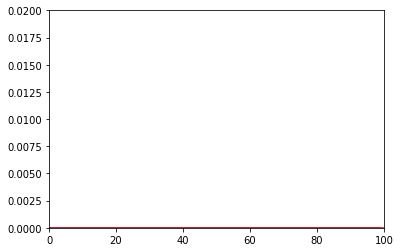

100%|██████████| 100/100 [00:32<00:00,  3.55it/s]

2.2079969852484282e-08 1.6814321952551836e-06


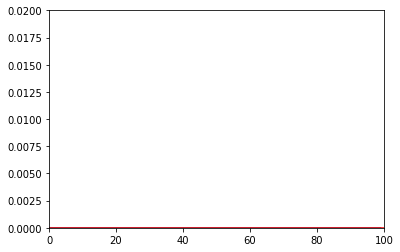

100%|██████████| 100/100 [00:33<00:00,  2.50it/s]

1.059292742411344e-08 4.05372520617675e-06


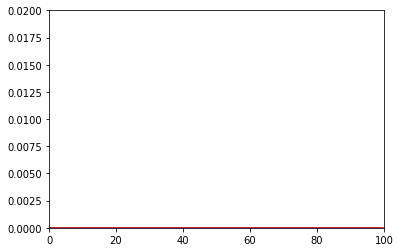

100%|██████████| 100/100 [00:31<00:00,  3.56it/s]

1.067032417978453e-08 4.916180841973983e-06


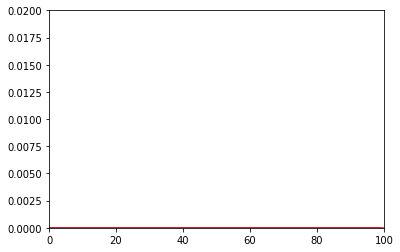

100%|██████████| 100/100 [00:34<00:00,  2.58it/s]

2.92182829042531e-08 2.5510325940558687e-06


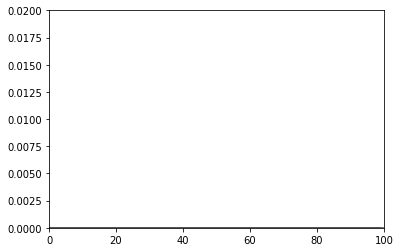

100%|██████████| 100/100 [00:30<00:00,  4.01it/s]

1.0820061646654722e-07 2.599538447611849e-06


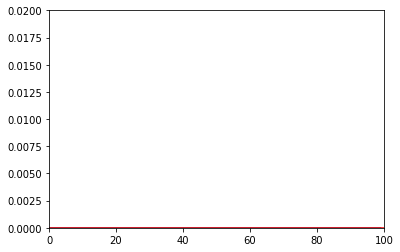

100%|██████████| 100/100 [00:34<00:00,  3.68it/s]

6.761880833039413e-09 6.2441372392640915e-06


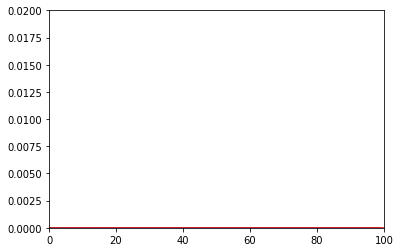

100%|██████████| 100/100 [00:29<00:00,  3.85it/s]

1.5415079701597278e-07 1.8299797375220805e-05


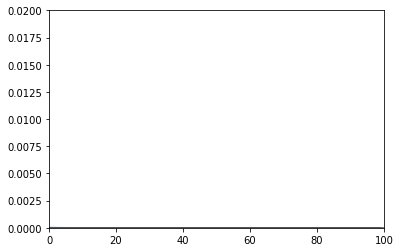

100%|██████████| 100/100 [00:34<00:00,  2.21it/s]

7.633850884758431e-08 1.991784756683046e-06


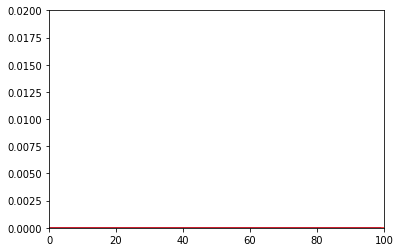

100%|██████████| 100/100 [00:31<00:00,  3.67it/s]

9.712004533923846e-09 1.9665812089897372e-08


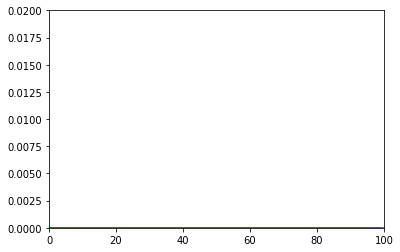

100%|██████████| 100/100 [00:32<00:00,  3.72it/s]

7.22361104266156e-09 3.6989895306760445e-06


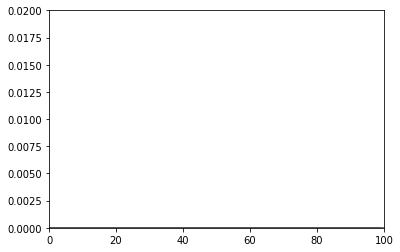

100%|██████████| 100/100 [00:32<00:00,  2.23it/s]

6.92151687076148e-08 2.584532558103092e-05


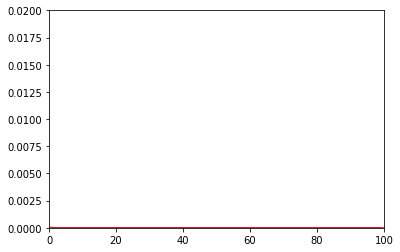

100%|██████████| 100/100 [00:32<00:00,  3.42it/s]

1.6218418608104912e-08 5.430814780993387e-06


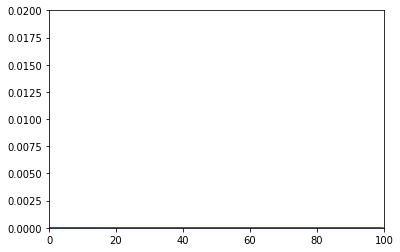

100%|██████████| 100/100 [00:31<00:00,  3.21it/s]

4.8662780471886435e-09 2.569247499195626e-06


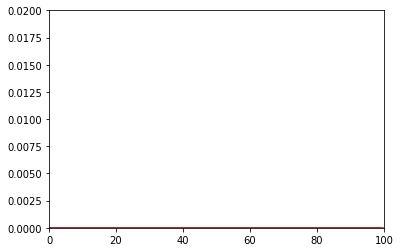

100%|██████████| 100/100 [00:35<00:00,  3.12it/s]

1.687524218141334e-07 8.480077667627484e-06


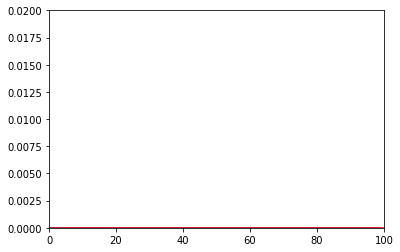

100%|██████████| 100/100 [00:33<00:00,  3.14it/s]

3.484185828739328e-09 7.390733571810415e-07


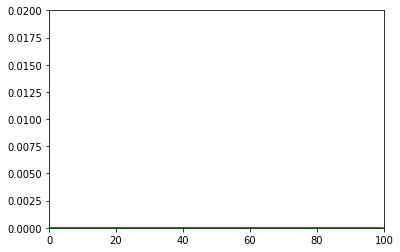

100%|██████████| 100/100 [00:30<00:00,  3.03it/s]

6.699622634442903e-09 1.5859255881878198e-06


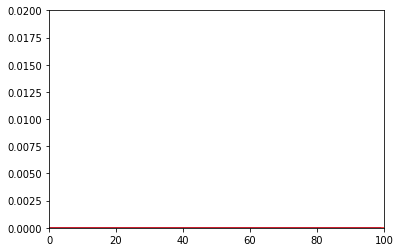

100%|██████████| 100/100 [00:33<00:00,  3.59it/s]

1.2807057636621266e-09 1.3817267472404637e-06


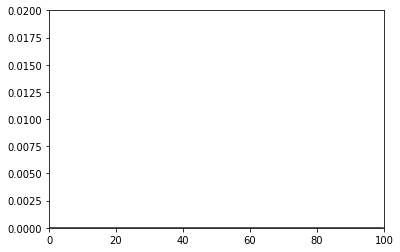

100%|██████████| 100/100 [00:29<00:00,  3.50it/s]


2.700965229252006e-09 3.4989872688129253e-07


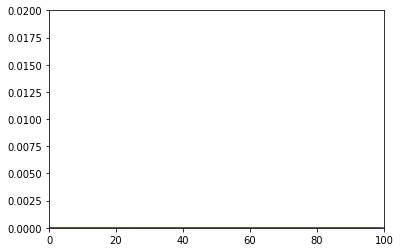

100%|██████████| 100/100 [00:33<00:00,  3.06it/s]


5.8665541757818573e-08 7.760669973322365e-07


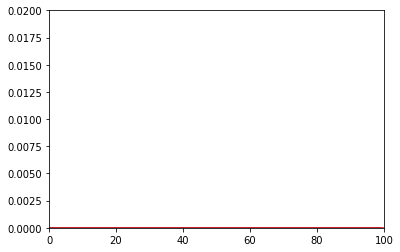

100%|██████████| 100/100 [00:30<00:00,  3.77it/s]

2.3797472437081524e-08 1.5196964113783906e-06


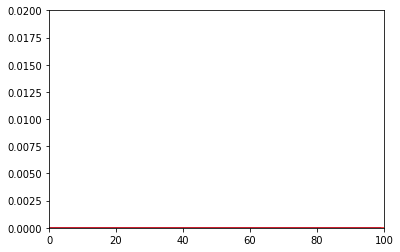

100%|██████████| 100/100 [00:34<00:00,  3.55it/s]

8.181834099119101e-10 2.5750006216185284e-07


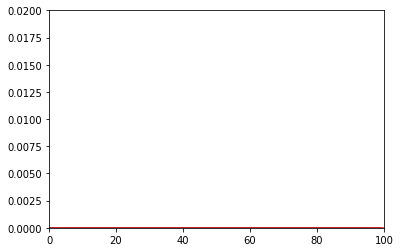

100%|██████████| 100/100 [00:31<00:00,  3.08it/s]

1.866187560040089e-08 1.050736386787321e-06


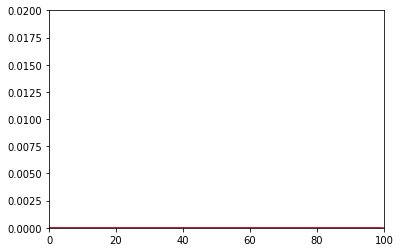

100%|██████████| 100/100 [00:33<00:00,  3.08it/s]

1.0465663002889869e-08 1.19864253065316e-05


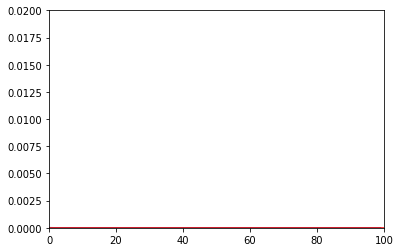

100%|██████████| 100/100 [00:30<00:00,  2.45it/s]

1.936830607007778e-08 2.333051452296786e-05


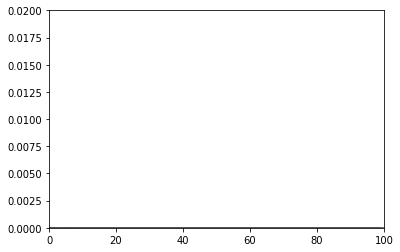

100%|██████████| 100/100 [00:32<00:00,  3.48it/s]

2.1592037047213353e-09 5.122826678416459e-07


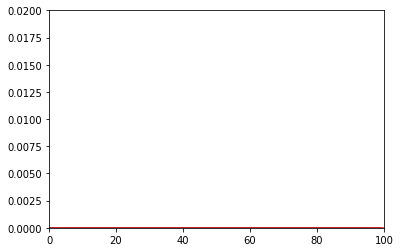

100%|██████████| 100/100 [00:32<00:00,  2.21it/s]

8.481290478812298e-07 4.491453182708938e-06


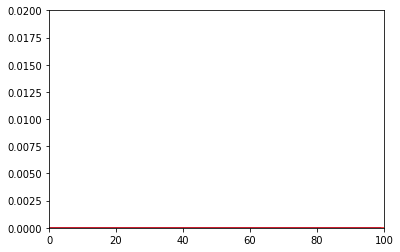

100%|██████████| 100/100 [00:32<00:00,  2.33it/s]

1.2931361759171978e-08 8.567752018961983e-08


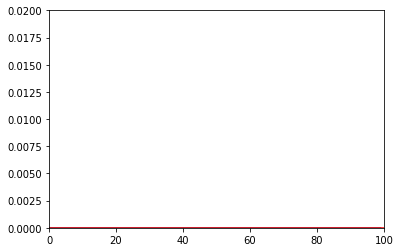

In [73]:
ncv_s = []
squeezed_weights = [[state_dict_to_vec(samples[i][0][j]) 
                     for j in range(len(samples[i][0]))]
                    for i in range(len(samples))]
psy_input_dim = squeezed_weights[0][0].shape[0]

for models, pr in zip(trajectories, priors):
    
    #psy_model = PsyConv(psy_input_dim, 75)
    psy_model = PsyLinear(psy_input_dim)
    #psy_model.init_zero()
    psy_model.to('cpu')

    neural_control_variate = SteinCV(psy_model, train_x, train_y, pr, N_train)

    ncv_optimizer = torch.optim.Adam(psy_model.parameters(), lr=args.cv_lr)
    uncertainty_quant = ClassificationUncertaintyMCMC(models, neural_control_variate)



    function_f = lambda model, x: get_binary_prediction(model, x, classes=[0, 1])
    history = [] 
    x = x_new[9:10]
    fig = plt.figure()

    data_iter = iter(train_dl)
    for it in tqdm(range(args.n_cv_iter)):
        try:
            train_x, train_y = next(data_iter)
        except:
            data_iter = iter(train_dl)
            train_x, train_y = next(data_iter)
        ncv_optimizer.zero_grad()
        #mc_variance = uncertainty_quant.estimate_emperical_variance(x, use_cv=True)
        mc_variance, no_cv_variance = compute_naive_variance(function_f, neural_control_variate, models, x)
        history.append(mc_variance.mean().item())
        mc_variance.mean().backward()
        ncv_optimizer.step()
    ncv_s.append(neural_control_variate)
    print(mc_variance.mean().item(), no_cv_variance.mean().item())
    plt.plot(np.arange(it+1), history)
    plt.axhline(y=no_cv_variance.mean(), color='r', linestyle='-')
    plt.xlim(0, args.n_cv_iter)
    plt.ylim(0, 0.02)
    plt.show()

In [32]:
neural_control_variate(models, x[20:21])

RuntimeError: stack expects a non-empty TensorList

In [74]:
psy_weights = [deepcopy(ncv.psy_model.state_dict()) for ncv in ncv_s]

In [78]:
psy_weights

[OrderedDict([('layer.weight',
               tensor([[-0.0209, -0.0109,  0.0244,  ...,  0.0044, -0.0145,  0.0185]])),
              ('layer.bias', tensor([0.0019]))]),
 OrderedDict([('layer.weight',
               tensor([[-0.0042,  0.0305,  0.0103,  ...,  0.0110, -0.0180, -0.0268]])),
              ('layer.bias', tensor([0.0003]))]),
 OrderedDict([('layer.weight',
               tensor([[ 0.0177, -0.0197, -0.0082,  ...,  0.0208, -0.0122,  0.0240]])),
              ('layer.bias', tensor([-0.0024]))]),
 OrderedDict([('layer.weight',
               tensor([[-0.0151, -0.0237, -0.0063,  ..., -0.0228,  0.0199, -0.0150]])),
              ('layer.bias', tensor([-0.0186]))]),
 OrderedDict([('layer.weight',
               tensor([[-0.0086,  0.0028, -0.0255,  ...,  0.0178, -0.0182,  0.0062]])),
              ('layer.bias', tensor([-0.0129]))]),
 OrderedDict([('layer.weight',
               tensor([[-0.0096, -0.0076,  0.0177,  ...,  0.0057, -0.0042,  0.0084]])),
              ('layer.bias', tens

In [76]:
with open('../data/psy_weights.pckl', 'wb') as fp:
    pickle.dump(psy_weights, fp)

In [77]:
import pickle
with open('../data/psy_weights.pckl', 'rb') as fp:
    psy_weights = pickle.load(fp)

In [80]:
from control_variates.cv_utils import trapezoidal_kernel, SpectralVariance

100%|██████████| 100/100 [00:18<00:00,  3.27it/s]

5.280174082145095e-05 4.001622801297344e-05


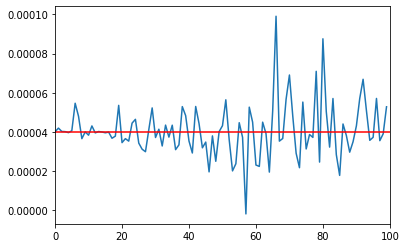

100%|██████████| 100/100 [00:18<00:00,  5.22it/s]

2.2941199858905748e-05 2.3986764063010924e-05


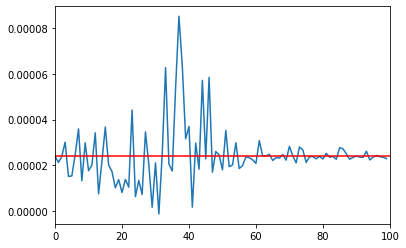

100%|██████████| 100/100 [00:16<00:00,  4.46it/s]

2.8114256565459073e-05 2.9958073355373926e-05


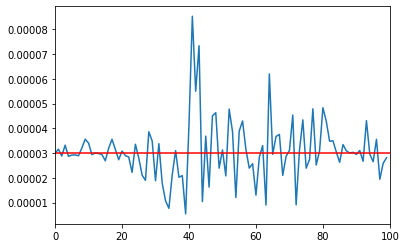

100%|██████████| 100/100 [00:17<00:00,  6.72it/s]


4.7018416807986796e-05 5.7395227486267686e-05


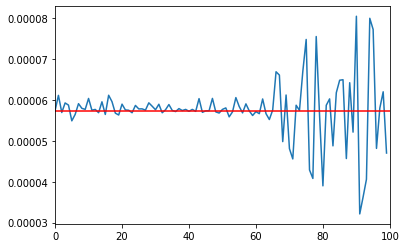

100%|██████████| 100/100 [00:19<00:00,  6.90it/s]


3.126018782495521e-05 2.29243487410713e-05


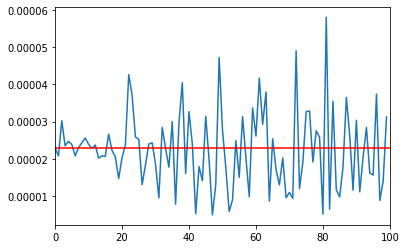

100%|██████████| 100/100 [00:17<00:00,  6.53it/s]


3.495710188872181e-05 4.545844785752706e-05


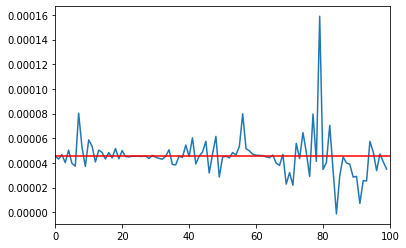

100%|██████████| 100/100 [00:16<00:00,  5.78it/s]


8.940627367337584e-07 3.599510819185525e-06


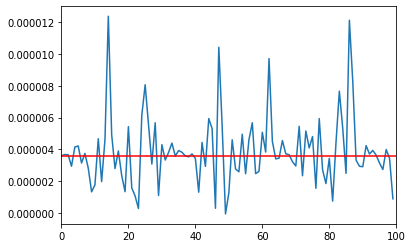

100%|██████████| 100/100 [00:19<00:00,  6.42it/s]


7.88918332546018e-05 7.91524289525114e-05


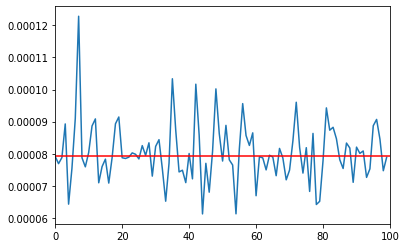

100%|██████████| 100/100 [00:17<00:00,  4.16it/s]

3.825268504442647e-05 2.3077982405084185e-05


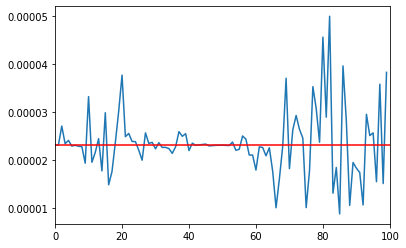

100%|██████████| 100/100 [00:16<00:00,  7.54it/s]


1.8907561752712354e-05 1.4148020454740617e-05


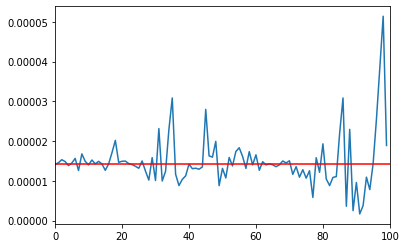

100%|██████████| 100/100 [00:17<00:00,  3.54it/s]

5.430719284049701e-06 5.528342171601253e-06


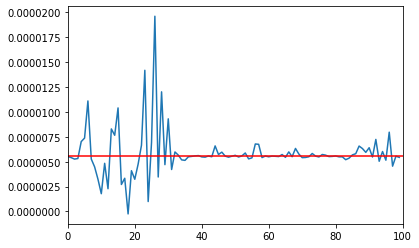

100%|██████████| 100/100 [00:18<00:00,  6.56it/s]


3.340071634738706e-05 2.913821481342893e-05


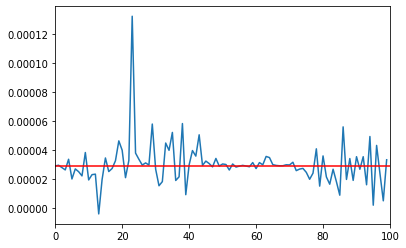

100%|██████████| 100/100 [00:17<00:00,  4.20it/s]


4.693685696111061e-06 4.921245363220805e-06


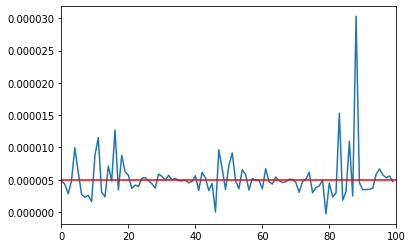

100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


1.2491957022575662e-05 1.1051862202293705e-05


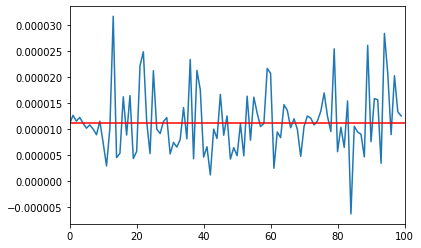

100%|██████████| 100/100 [00:19<00:00,  5.18it/s]

2.5480085241724737e-05 2.538874832680449e-05


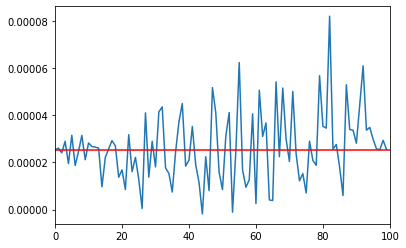

100%|██████████| 100/100 [00:17<00:00,  6.35it/s]


8.371416129193676e-07 1.830038740990858e-06


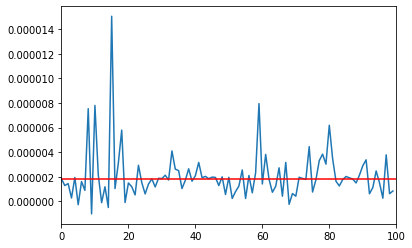

100%|██████████| 100/100 [00:16<00:00,  3.25it/s]

0.00013106520054861903 0.00010347459465265274


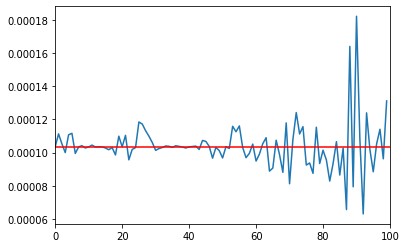

100%|██████████| 100/100 [00:19<00:00,  6.32it/s]


1.2006278666376602e-05 8.000300113053527e-06


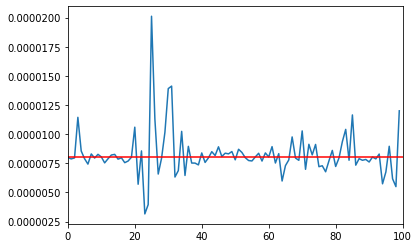

100%|██████████| 100/100 [00:15<00:00,  7.86it/s]


1.3052809663349763e-05 1.8899389033322223e-05


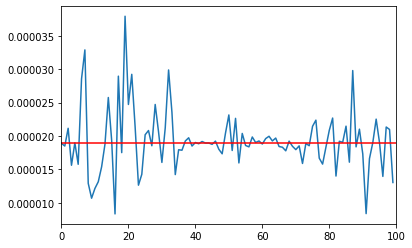

100%|██████████| 100/100 [00:16<00:00,  7.25it/s]


4.674952833738644e-06 5.874543603567872e-06


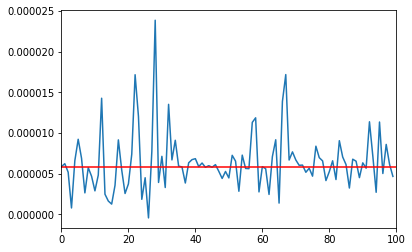

100%|██████████| 100/100 [00:16<00:00,  6.86it/s]


7.8756500442978e-05 7.28773302398622e-05


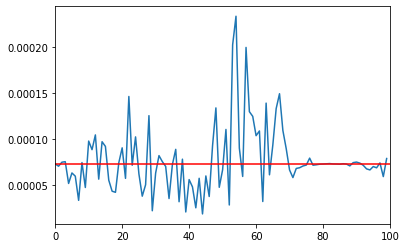

100%|██████████| 100/100 [00:18<00:00,  6.10it/s]


5.805057298857719e-06 6.998224307608325e-06


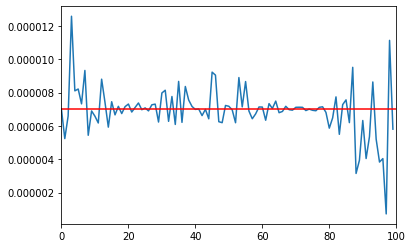

100%|██████████| 100/100 [00:16<00:00,  6.13it/s]


0.00010925975948339328 0.00016229080210905522


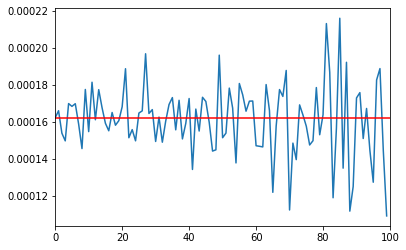

100%|██████████| 100/100 [00:15<00:00,  5.59it/s]


1.3766672054771334e-05 9.551618859404698e-06


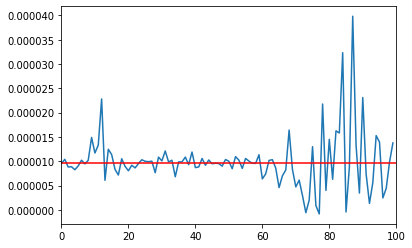

100%|██████████| 100/100 [00:18<00:00,  6.89it/s]


7.74926520534791e-05 7.032649591565132e-05


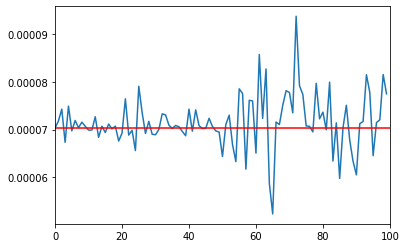

100%|██████████| 100/100 [00:18<00:00,  6.10it/s]


1.4744254258403089e-05 5.5223149502126034e-06


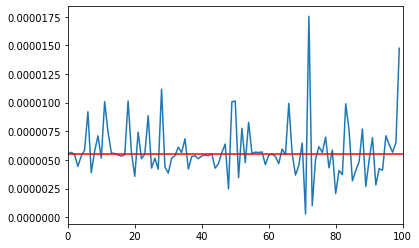

100%|██████████| 100/100 [00:15<00:00,  7.89it/s]


4.986367639503442e-05 5.1054586947429925e-05


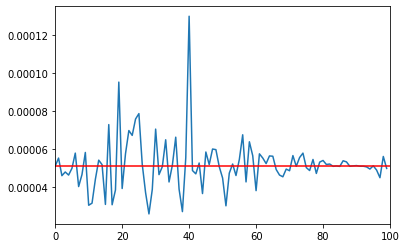

100%|██████████| 100/100 [00:18<00:00,  3.59it/s]


8.976553544925991e-06 2.5386982088093646e-05


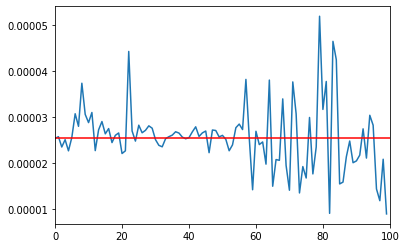

100%|██████████| 100/100 [00:18<00:00,  5.20it/s]

1.6006517398636788e-05 1.61911993927788e-05


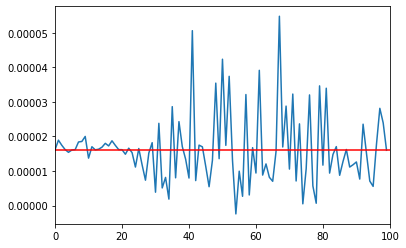

100%|██████████| 100/100 [00:17<00:00,  7.41it/s]


1.6288940969388932e-05 1.8000204363488592e-05


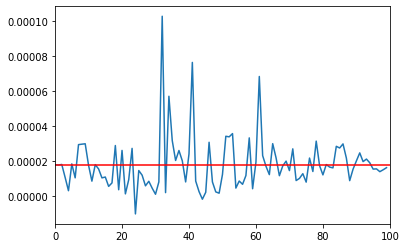

100%|██████████| 100/100 [00:16<00:00,  5.95it/s]

0.0010084840469062328 0.0010204993886873126


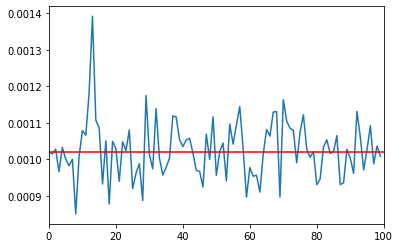

100%|██████████| 100/100 [00:21<00:00,  3.24it/s]

1.4437915751841501e-06 7.462555799975235e-07


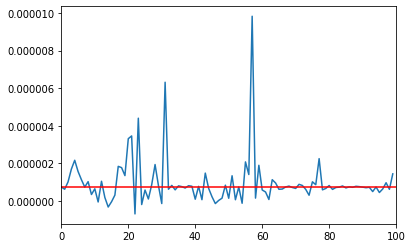

100%|██████████| 100/100 [00:15<00:00,  6.91it/s]


3.2525778806302696e-05 1.944399264175445e-05


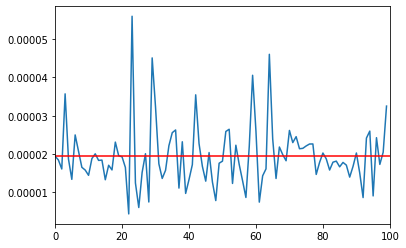

100%|██████████| 100/100 [00:16<00:00,  6.55it/s]


9.044131729751825e-05 7.7117707405705e-05


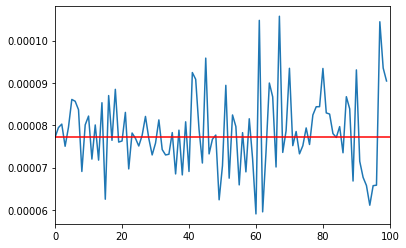

100%|██████████| 100/100 [00:18<00:00,  5.71it/s]

0.00036938535049557686 0.0003640214563347399


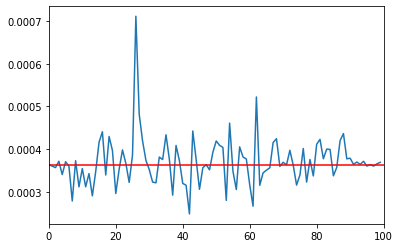

100%|██████████| 100/100 [00:16<00:00,  6.13it/s]


8.979962331068236e-06 8.94053573574638e-06


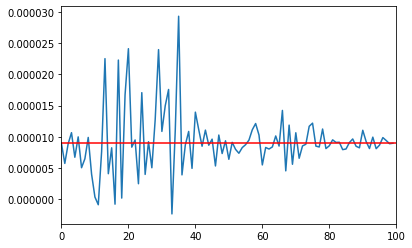

100%|██████████| 100/100 [00:16<00:00,  5.20it/s]

0.000210188067285344 0.00010971402662107721


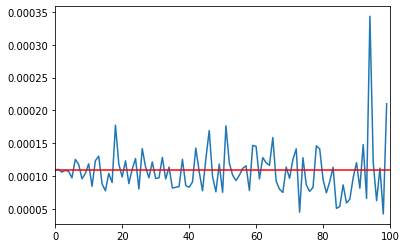

100%|██████████| 100/100 [00:17<00:00,  6.82it/s]


1.919524402183015e-05 1.679374872765038e-05


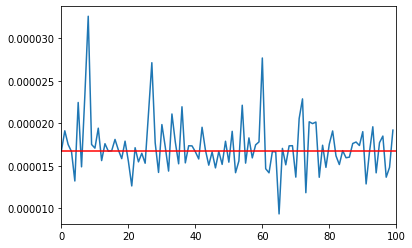

100%|██████████| 100/100 [00:19<00:00,  5.45it/s]

8.359635103261098e-05 8.25650931801647e-05


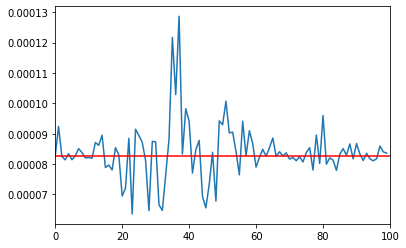

100%|██████████| 100/100 [00:17<00:00,  6.91it/s]


6.103730356699089e-06 5.442207111627795e-06


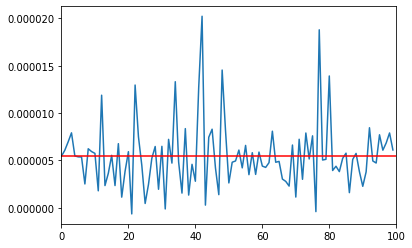

100%|██████████| 100/100 [00:16<00:00,  6.36it/s]


1.2076376151526347e-05 1.4188621207722463e-05


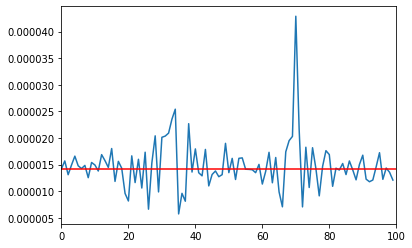

100%|██████████| 100/100 [00:20<00:00,  5.66it/s]


2.3668530957365874e-06 2.2339072529575787e-06


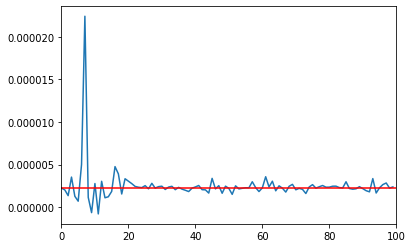

100%|██████████| 100/100 [00:15<00:00,  7.26it/s]


4.398985311127035e-06 4.490022547543049e-06


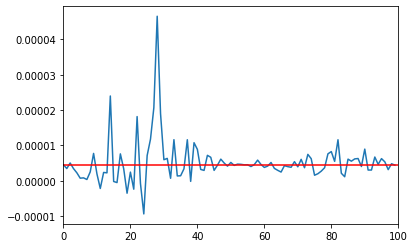

100%|██████████| 100/100 [00:16<00:00,  6.95it/s]


6.082393156248145e-05 6.277699139900506e-05


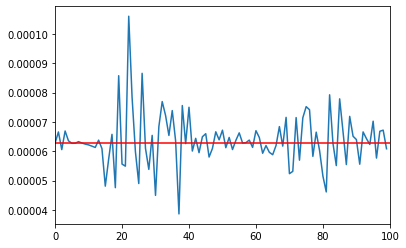

100%|██████████| 100/100 [00:15<00:00,  6.95it/s]


8.748869731789455e-05 0.0001417750318069011


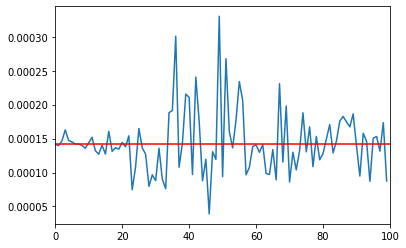

100%|██████████| 100/100 [00:19<00:00,  5.80it/s]


0.0001751543313730508 0.0001723213354125619


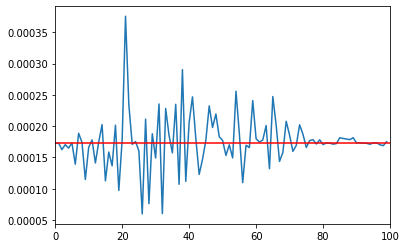

100%|██████████| 100/100 [00:16<00:00,  7.47it/s]


0.00015211975551210344 0.0001456960162613541


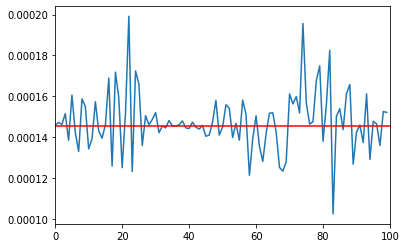

100%|██████████| 100/100 [00:16<00:00,  6.12it/s]


5.881202014279552e-05 5.5230080761248246e-05


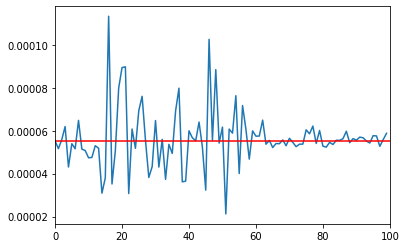

100%|██████████| 100/100 [00:19<00:00,  7.26it/s]


1.6720495921163092e-07 4.587883267959114e-06


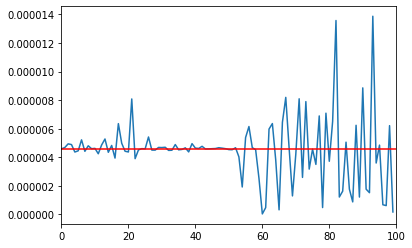

100%|██████████| 100/100 [00:17<00:00,  6.91it/s]


8.055285434238613e-07 1.2515952221292537e-06


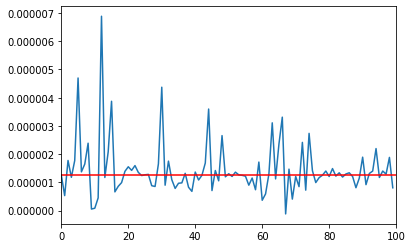

100%|██████████| 100/100 [00:17<00:00,  6.14it/s]

1.24404214147944e-05 1.6133697499753907e-05


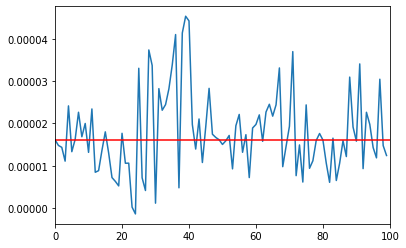

100%|██████████| 100/100 [00:16<00:00,  6.57it/s]


0.00038240887806750834 0.0003305990539956838


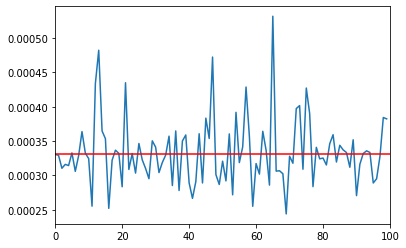

100%|██████████| 100/100 [00:19<00:00,  6.26it/s]


1.2548458698802278e-06 1.6900943364817067e-06


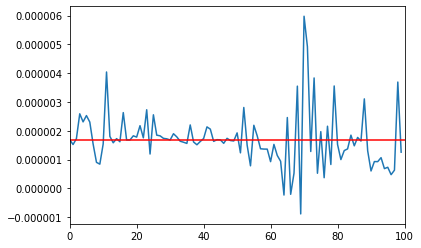

100%|██████████| 100/100 [00:17<00:00,  7.58it/s]


5.813416282762773e-05 6.741499964846298e-05


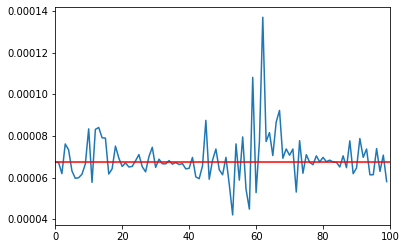

100%|██████████| 100/100 [00:17<00:00,  7.91it/s]


3.293394183856435e-05 3.2380376069340855e-05


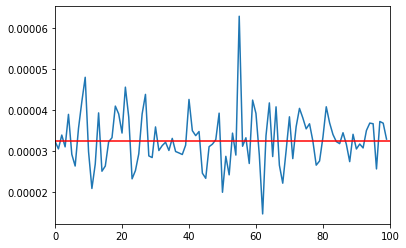

100%|██████████| 100/100 [00:19<00:00,  4.77it/s]


6.454205140471458e-05 5.8981884649256244e-05


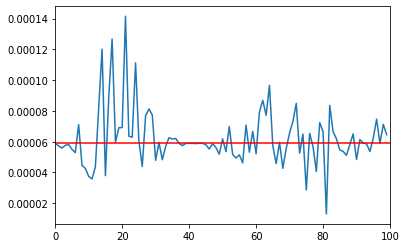

100%|██████████| 100/100 [00:17<00:00,  7.35it/s]


5.021480319555849e-06 6.216370820766315e-06


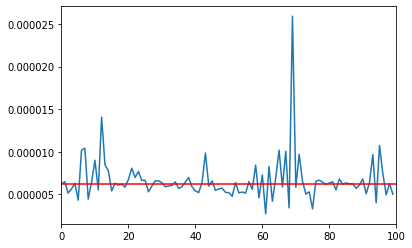

100%|██████████| 100/100 [00:16<00:00,  5.73it/s]


0.00011199196887901053 0.00011461380199762061


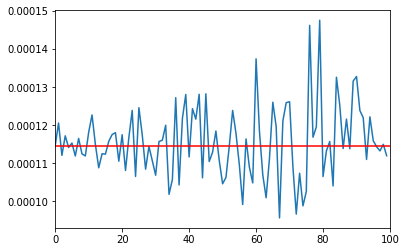

100%|██████████| 100/100 [00:19<00:00,  7.06it/s]


1.4921962247171905e-05 1.3476560525305104e-05


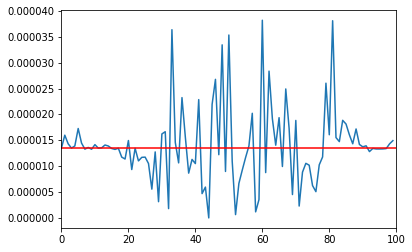

100%|██████████| 100/100 [00:17<00:00,  6.71it/s]


3.675116204249207e-06 5.777018941444112e-06


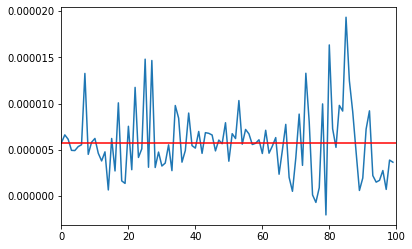

100%|██████████| 100/100 [00:16<00:00,  5.07it/s]


7.872194146330003e-06 2.88812157123175e-06


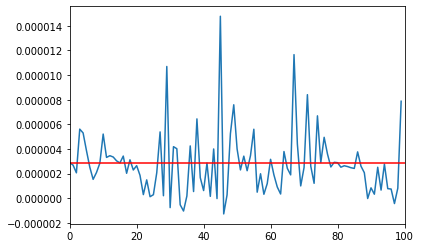

100%|██████████| 100/100 [00:17<00:00,  3.89it/s]

2.6396264729555696e-05 2.9095883292029612e-05


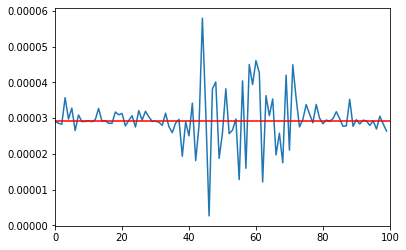

100%|██████████| 100/100 [00:20<00:00,  4.62it/s]

9.180402412312105e-05 7.089962309692055e-05


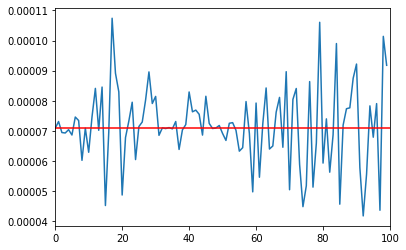

100%|██████████| 100/100 [00:16<00:00,  6.87it/s]


8.537484973203391e-05 8.549763879273087e-05


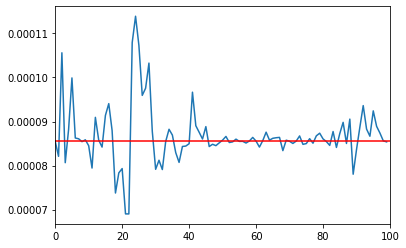

100%|██████████| 100/100 [00:16<00:00,  4.67it/s]

3.6648016248364e-05 4.417377931531519e-05


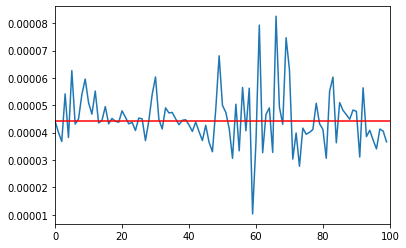

100%|██████████| 100/100 [00:20<00:00,  4.21it/s]


4.296837141737342e-05 4.5086926547810435e-05


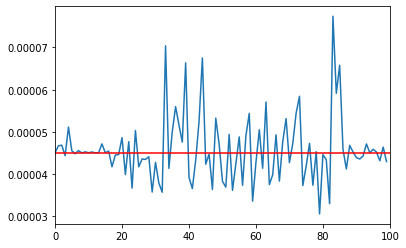

 58%|█████▊    | 58/100 [00:09<00:05,  7.46it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [82]:
ncv_s2 = []
for models, pr in zip(trajectories, priors):
    psy_model = PsyLinear(psy_input_dim)
    psy_model.init_zero()
    psy_model.to('cpu')

    neural_control_variate = SteinCV(psy_model, train_x, train_y, priors, N_train)
    function_f = lambda model, x: get_binary_prediction(model, x, classes=[0, 1])

    function_h = lambda model, x: function_f(model, x) - neural_control_variate(model, x)

    window_lag_f = trapezoidal_kernel
    truncation_point = len(models) // 2
    spectral_loss = SpectralVariance(function_h, models, window_lag_f, truncation_point)
    no_cv_loss = SpectralVariance(function_f, models, window_lag_f, truncation_point)

    ncv_optimizer = torch.optim.Adam(psy_model.parameters(), lr=args.cv_lr)

    history = [] 
    x = x_new[9:10]
    fig = plt.figure()

    no_cv_variance = no_cv_loss(x)

    data_iter = iter(train_dl)
    for it in tqdm(range(args.n_cv_iter)):
        try:
            train_x, train_y = next(data_iter)
        except:
            data_iter = iter(train_dl)
            train_x, train_y = next(data_iter)
        neural_control_variate.train_x = train_x
        neural_control_variate.train_y = train_y
        ncv_optimizer.zero_grad()
        mc_variance = spectral_loss(x)
        history.append(mc_variance.mean().item())
        mc_variance.backward()
        ncv_optimizer.step()
    ncv_s2.append(neural_control_variate)
    print(mc_variance.mean().item(), no_cv_variance.mean().item())
    plt.plot(np.arange(it+1), history)
    plt.axhline(y=no_cv_variance.mean(), color='r', linestyle='-')
    plt.xlim(0, args.n_cv_iter)
    plt.show()

In [83]:
psy_weights2 = [deepcopy(ncv.psy_model.state_dict()) for ncv in ncv_s2]

In [84]:
with open('../data/psy_weights2.pckl', 'wb') as fp:
    pickle.dump(psy_weights2, fp)